In [1]:
import os
import sys
import torch
import torchvision
import nngen as ng
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
vgg11 = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights)

/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### 手書きGrad-CAM

In [4]:
class Conv:
    def __init__(self, in_channels, out_channels, params=None, pool=True):
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = pool
        self.set(params)
    def set(self, params=None):
        if params is not None:
            self.conv.weight = params.weight
            self.conv.bias = params.bias
    def forward(self, x):
        conved = self.conv(x)
        out = torch.relu(conved)
        if self.pool:
            out = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(out)
        return out

class Linear:
    def __init__(self, in_features, out_features, params=None, relu=True):
        self.linear = torch.nn.Linear(in_features=in_features, out_features=out_features, bias=True)
        self.relu = relu
        self.set(params)
    def set(self, params=None):
        if params is not None:
            self.linear.weight = params.weight
            self.linear.bias = params.bias
    def forward(self, x):
        out = self.linear(x)
        if self.relu:
            out = torch.relu(out)
        return out

In [5]:
img_path = "african_elephant.jpg"
img = Image.open(img_path)
img = torchvision.models.VGG11_Weights.IMAGENET1K_V1.transforms()(img)
tx = img[None]
print(tx.shape)

torch.Size([1, 3, 224, 224])


In [6]:
ty1 = Conv(3, 64, vgg11.features[0]).forward(tx)
ty2 = Conv(64, 128, vgg11.features[3]).forward(ty1)
ty3 = Conv(128, 256, vgg11.features[6], False).forward(ty2)
ty4 = Conv(256, 256, vgg11.features[8]).forward(ty3)
ty5 = Conv(256, 512, vgg11.features[11], False).forward(ty4)
ty6 = Conv(512, 512, vgg11.features[13]).forward(ty5)
ty7 = Conv(512, 512, vgg11.features[16], False).forward(ty6)
ty = Conv(512, 512, vgg11.features[18]).forward(ty7)
print(ty.shape)

torch.Size([1, 512, 7, 7])


In [7]:
# z = torch.nn.AvgPool2d(stride=1, kernel_size=1, padding=0)(y)
tz1 = torch.flatten(ty, 1)
tl2 = Linear(25088, 4096, vgg11.classifier[0])
tz2 = tl2.forward(tz1)
tz3 = Linear(4096, 4096, vgg11.classifier[3]).forward(tz2)
tz = Linear(4096, 1000, vgg11.classifier[6], False).forward(tz3)
print(tz.shape)

torch.Size([1, 1000])


In [8]:
torch_res = tz[0]
ans = tz.argmax(1).item()
print(ans)

386


In [9]:
ty.retain_grad()
tz[0][ans].backward()
tdA = ty.grad[0].numpy()
print(tdA.shape)
tA = ty[0].detach().numpy()

(512, 7, 7)


In [10]:
def relu(x):
    return np.where(x > 0, x, np.zeros_like(x))

tw = tdA.sum((1, 2)) / 49
twA = (np.tile(tw, (7, 7, 1)).transpose((2, 0, 1))) * tA
tcam = relu(twA.sum(0))
print(tcam.shape)

(7, 7)


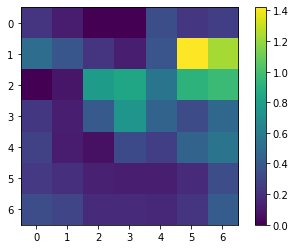

In [11]:
plt.imshow(tcam)
plt.colorbar()

### VGG11 in NNgen

In [12]:
# data types
act_dtype = ng.int16
weight_dtype = ng.int16
bias_dtype = ng.int32
scale_dtype = ng.int16
sum_dtype = ng.int32
batchsize = 1

In [13]:
class Conv:
    def __init__(self, in_channels, out_channels, params=None, pool=True):
        self.weight = ng.variable(dtype=weight_dtype, shape=(out_channels, 3, 3, in_channels))
        self.bias = ng.variable(dtype=bias_dtype, shape=(self.weight.shape[0],))
        self.scale = ng.variable(dtype=scale_dtype, shape=(self.weight.shape[0],))

        self.pool = pool
        self.set(params)
    def set(self, params=None):
        self.scale.set_value(np.ones(self.scale.shape))
        if params is not None:
            self.weight.set_value(params.weight.detach().numpy().transpose(0, 2, 3, 1))
            self.bias.set_value(params.bias.detach().numpy())
    def forward(self, x):
        out = ng.conv2d(x, self.weight,
                            strides=(1, 1, 1, 1),
                            padding=1,
                            bias=self.bias,
                            scale=self.scale,
                            act_func=ng.relu,
                            dtype=act_dtype,
                            sum_dtype=sum_dtype)
        if self.pool:
            pooled = ng.max_pool(out, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding=0)
            return pooled
        else:
            return out

class Linear:
    def __init__(self, in_features, out_features, params=None, relu=True):
        self.weight = ng.variable(dtype=weight_dtype, shape=(out_features, in_features))
        self.bias = ng.variable(dtype=bias_dtype, shape=(self.weight.shape[0],))
        self.scale = ng.variable(dtype=scale_dtype, shape=(self.weight.shape[0],))

        self.relu = relu
        self.set(params)
    def set(self, params=None):
        self.scale.set_value(np.ones(self.scale.shape))
        if params is not None:
            self.weight.set_value(params.weight.detach().numpy())
            self.bias.set_value(params.bias.detach().numpy())
    def set_weight(self, w):
        if torch.is_tensor(w):
            w = w.detach().numpy()
        self.weight.set_value(w)
    def set_bias(self, w):
        if torch.is_tensor(w):
            w = w.detach().numpy()
        self.bias.set_value(w)
    def forward(self, x):
        out = ng.matmul(x, self.weight, bias=self.bias, scale=self.scale, transposed_b=True,
                        act_func=ng.relu if self.relu else None,
                        dtype=act_dtype, sum_dtype=sum_dtype)
        return out

In [14]:
nx = ng.placeholder(dtype=act_dtype, shape=(batchsize, 224, 224, 3), name="nx")
ny1 = Conv(3, 64, vgg11.features[0]).forward(nx)
ny2 = Conv(64, 128, vgg11.features[3]).forward(ny1)
ny3 = Conv(128, 256, vgg11.features[6], False).forward(ny2)
ny4 = Conv(256, 256, vgg11.features[8]).forward(ny3)
ny5 = Conv(256, 512, vgg11.features[11], False).forward(ny4)
ny6 = Conv(512, 512, vgg11.features[13]).forward(ny5)
ny7 = Conv(512, 512, vgg11.features[16], False).forward(ny6)
ny = Conv(512, 512, vgg11.features[18]).forward(ny7)
print(ny.shape)

(1, 7, 7, 512)


In [15]:
nz1 = ng.reshape(ng.transpose(ny, (0, 3, 1, 2)), [batchsize, -1])
nl2 = Linear(25088, 4096, vgg11.classifier[0])
nz2 = nl2.forward(nz1)
nz3 = Linear(4096, 4096, vgg11.classifier[3]).forward(nz2)
nz = Linear(4096, 1000, vgg11.classifier[6], False).forward(nz3)
print(nz.shape)

nzcl = Linear(4096, 1, None, False)
nzcl.set_weight(vgg11.classifier[6].weight[ans][None])
nzcl.set_bias(vgg11.classifier[6].bias[ans][None])
nzc = nzcl.forward(nz3)

(1, 1000)


In [16]:
imagenet_mean = np.array([0.485, 0.456, 0.406]).astype(np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225]).astype(np.float32)

if act_dtype.width > 8:
    act_scale_factor = 128
else:
    act_scale_factor = int(round(2 ** (act_dtype.width - 1) * 0.5))
print(act_scale_factor)

input_scale_factors = {'nx': act_scale_factor}
input_means = {'nx': imagenet_mean * act_scale_factor}
input_stds = {'nx': imagenet_std * act_scale_factor}

ng.quantize([nzc], input_scale_factors, input_means, input_stds)

128


In [17]:
# img_path = "african_elephant.jpg"
img = Image.open(img_path)
img = torchvision.models.VGG11_Weights.IMAGENET1K_V1.transforms()(img)
img = img.numpy().transpose((1, 2, 0))[None]
print(img.shape)

img = np.clip(img, -3.0, 3.0)
img = img * act_scale_factor
img = np.clip(img, -1 * 2 ** (act_dtype.width - 1) - 1, 2 ** (act_dtype.width - 1))
img = np.round(img).astype(np.int64)
print(img[0][0][0])

(1, 224, 224, 3)
[169 232 291]


In [18]:
print(ng.eval([nzc], nx=img)[0])

gradient = ng.gradient(nzc, nz1)
print(gradient[0][:5], end='\n\n')

[[32767]]
[-1232  -272 -3330 -4973 -5177]



In [19]:
def relu(x):
    return np.where(x > 0, x, np.zeros_like(x))

ndA = gradient[0].reshape((512, 7, 7))
nA = ng.eval([ny], nx=img)[0][0]

nw = ndA.sum((1, 2)) / 49
nwA = (np.tile(nw, (7, 7, 1))) * nA
ncam = relu(nwA.sum(2))
print(ncam.shape)

(7, 7)


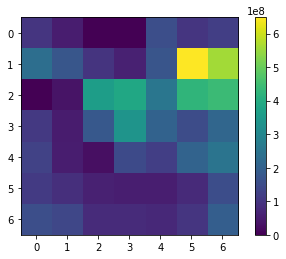

In [20]:
plt.imshow(ncam)
plt.colorbar()

In [21]:
def corrcoef(x, y):
    if torch.is_tensor(x):
        x = x.detach().numpy()
        if len(x.shape) == 4:
            x = x.transpose(0, 2, 3, 1)
    if torch.is_tensor(y):
        y = y.detach().numpy()
        if len(y.shape) == 4:
            y = y.transpose(0, 2, 3, 1)
    return np.corrcoef(x.flatten(), y.flatten())[0][1]

corrcoef(tcam, ncam)

0.999870427084722